In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score, make_scorer, f1_score, accuracy_score

In [3]:
with open('AGdata013019.pkl','rb') as f:
    AG_geneIDs, AGdata_outcome, AGdata_clean = pickle.load(f)

Omit MOA columns as features

In [5]:
AGdata_clean.drop(['CWSI', 'DSI', 'LIP', 'NTR', 'PSI', 'RSI'], axis=1, inplace=True)

In [6]:
selectexpts = AG_geneIDs.Experiment!="T4_DAP"
selectgenes = AG_geneIDs.Gene != "SP_1772"
AGdata_clean = AGdata_clean.loc[selectexpts & selectgenes,:]
AG_geneIDs = AG_geneIDs.loc[selectexpts & selectgenes,:]
AGdata_outcome = AGdata_outcome[selectexpts & selectgenes]

In [7]:
X = StandardScaler().fit_transform(AGdata_clean)

y = AGdata_outcome
X_test = X[(AG_geneIDs.Experiment=="T4_PEN")  | 
           (AG_geneIDs.Experiment=="T4_CIP") | (AG_geneIDs.Experiment=='19F_CIP') | 
           (AG_geneIDs.Experiment=="T4_RIF") | (AG_geneIDs.Experiment=='19F_RIF'),:]
X_train = X[(AG_geneIDs.Experiment!="T4_PEN") & 
            (AG_geneIDs.Experiment!="T4_CIP") & (AG_geneIDs.Experiment!='19F_CIP') & 
            (AG_geneIDs.Experiment!="T4_RIF") & (AG_geneIDs.Experiment!='19F_RIF') ,:]

y_test = y[(AG_geneIDs.Experiment=="T4_PEN")  | 
           (AG_geneIDs.Experiment=="T4_CIP") | (AG_geneIDs.Experiment=='19F_CIP') | 
           (AG_geneIDs.Experiment=="T4_RIF") | (AG_geneIDs.Experiment=='19F_RIF') ]
y_train = y[(AG_geneIDs.Experiment!="T4_PEN") & 
            (AG_geneIDs.Experiment!="T4_CIP") & (AG_geneIDs.Experiment!='19F_CIP') & 
            (AG_geneIDs.Experiment!="T4_RIF") & (AG_geneIDs.Experiment!='19F_RIF')]

AG_geneIDs_test = AG_geneIDs.loc[(AG_geneIDs.Experiment=="T4_PEN")  | 
                                 (AG_geneIDs.Experiment=="T4_CIP") | (AG_geneIDs.Experiment=='19F_CIP') | 
                                 (AG_geneIDs.Experiment=="T4_RIF") | (AG_geneIDs.Experiment=='19F_RIF'),:]
AG_geneIDs_train = AG_geneIDs.loc[(AG_geneIDs.Experiment!="T4_PEN") & 
                                  (AG_geneIDs.Experiment!="T4_CIP") & (AG_geneIDs.Experiment!='19F_CIP') &
                                  (AG_geneIDs.Experiment!="T4_RIF") & (AG_geneIDs.Experiment!='19F_RIF'),:]

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
kappa_scorer = make_scorer(cohen_kappa_score)

def fit_model(myclf, traindata, testdata, trainoutcome, testoutcome):
    myclf.fit(traindata, trainoutcome)
    print("Best Model:")
    print(myclf.best_estimator_)
    
    y_pred_train = myclf.best_estimator_.predict(traindata)
    y_pred_test = myclf.best_estimator_.predict(testdata)
    
    y_predprob_train = myclf.best_estimator_.predict_proba(traindata)[:, 1]
    y_predprob_test = myclf.best_estimator_.predict_proba(testdata)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(trainoutcome, y_predprob_train)
    fpr_test, tpr_test, _ = roc_curve(testoutcome, y_predprob_test)
    
    acc_train = accuracy_score(trainoutcome, y_pred_train)
    acc_test = accuracy_score(testoutcome, y_pred_test)
    kap_train = cohen_kappa_score(trainoutcome, y_pred_train)
    kap_test = cohen_kappa_score(testoutcome, y_pred_test)
    
    cm_train = confusion_matrix(trainoutcome, y_pred_train)
    cm_test = confusion_matrix(testoutcome, y_pred_test)
    print("Training set confusion matrix:")
    print(cm_train)
    print("Test set confusion matrix:")
    print(cm_test)
    
    x = pd.DataFrame({'Train_Accuracy': [acc_train],
        'Test_Accuracy': [acc_test],
        'Train_Kappa': [kap_train],
        'Test_Kappa': [kap_test]})
    print(x)
    train_outcome_df = pd.DataFrame({'Outcome': trainoutcome,
                                    'Predicted': y_pred_train})
    test_outcome_df = pd.DataFrame({'Outcome': testoutcome,
                                   'Predicted': y_pred_test})
    
    
    # plot ROC
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot(fpr_test, tpr_test, label='Test')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.show()
    
    return(myclf, x, train_outcome_df, test_outcome_df)

Best Model:
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
Training set confusion matrix:
[[15762  1023]
 [    1    54]]
Test set confusion matrix:
[[8805  617]
 [  14    5]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.939192       0.933164     0.089749    0.011741


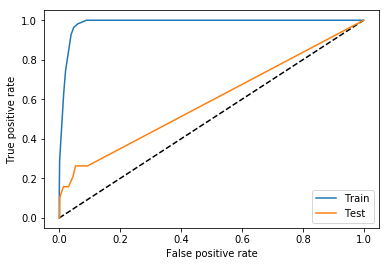

In [9]:
min_samples_split_DT = [3,4,5,6,7,8,9]
min_samples_leaf_DT = [3,4,5,6,7,8,9]
max_depth_DT = [3,4,5,6,7,8,9,10]
max_features_DT = ['sqrt', 'log2', None, 1, 2, 3, 4, 5]

parameters_DT = {#'max_features':max_features_DT,
                'min_samples_split': min_samples_split_DT,
                 'max_depth': max_depth_DT,
                'min_samples_leaf': min_samples_leaf_DT
                }

DT_model = DecisionTreeClassifier(random_state=0, splitter='best', criterion='gini', class_weight='balanced')
DT_clf = GridSearchCV(DT_model, parameters_DT, cv=5, scoring=kappa_scorer)
DT_clf, DT_performance, DT_train, DT_test = fit_model(DT_clf, X_train, X_test, y_train, y_test)
DT_train = pd.concat([DT_train, AG_geneIDs_train], axis=1)
DT_test = pd.concat([DT_test, AG_geneIDs_test], axis=1)

DT_train.to_csv('DT_train_noDAP_outcome022619.csv')
DT_test.to_csv('DT_test_noDAP_outcome022619.csv')

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
 

Best Model:
LogisticRegression(C=13.89495494373136, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Training set confusion matrix:
[[13181  3604]
 [   10    45]]
Test set confusion matrix:
[[8083 1339]
 [   8   11]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.785392       0.857324     0.017979    0.012149


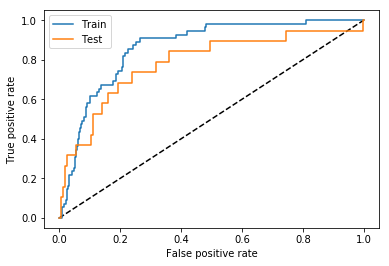

In [10]:
penalty_list_LR = ['l1','l2']
regularization_list_LR = [i for i in np.logspace(-4,2,15)]
parameters_LR = {'penalty':penalty_list_LR,
                'C': regularization_list_LR}

LR_model = LogisticRegression(class_weight = 'balanced')
LR_clf = GridSearchCV(LR_model, parameters_LR, cv=5, scoring=kappa_scorer)

LR_clf, LR_performance, LR_train, LR_test = fit_model(LR_clf, X_train, X_test, y_train, y_test)

LR_train = pd.concat([LR_train, AG_geneIDs_train], axis=1)
LR_test = pd.concat([LR_test, AG_geneIDs_test], axis=1)

LR_train.to_csv('LR_train_noDAP_outcome022619.csv')
LR_test.to_csv('LR_test_noDAP_outcome022619.csv')

Best Model:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='distance')
Training set confusion matrix:
[[16785     0]
 [    0    55]]
Test set confusion matrix:
[[9406   16]
 [  17    2]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0             1.0       0.996505          1.0    0.106358


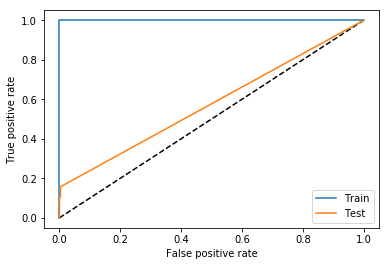

In [11]:
nneighbors_KNN = [i+2 for i in range(10)]
weights_list_KNN = ['uniform', 'distance']
parameters_KNN = {'n_neighbors':nneighbors_KNN,
                'weights': weights_list_KNN}
KNN_model = KNeighborsClassifier()
KNN_clf = GridSearchCV(KNN_model, parameters_KNN, cv=5, scoring=kappa_scorer)
KNN_clf, KNN_performance, KNN_train, KNN_test = fit_model(KNN_clf, X_train, X_test, y_train, y_test)

KNN_train = pd.concat([KNN_train, AG_geneIDs_train], axis=1)
KNN_test = pd.concat([KNN_test, AG_geneIDs_test], axis=1)

KNN_train.to_csv('KNN_train_noDAP_outcome022619.csv')
KNN_test.to_csv('KNN_test_noDAP_outcome022619.csv')

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

Best Model:
SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training set confusion matrix:
[[15222  1563]
 [    0    55]]
Test set confusion matrix:
[[8919  503]
 [  10    9]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.907185       0.945663     0.059811    0.030134


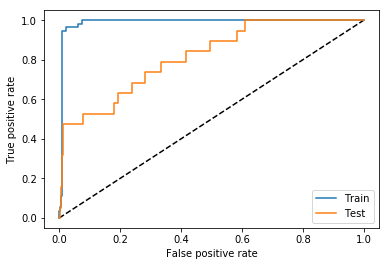

In [13]:
shrinking_list_SVM = [True, False]
regularization_list_SVM = [i for i in np.logspace(-4,-1,15)]
parameters_SVM = {'shrinking':shrinking_list_SVM,
                'C': regularization_list_SVM}

SVM_model = svm.SVC(class_weight='balanced', probability=True)
SVM_clf = GridSearchCV(SVM_model, parameters_SVM, cv=5, scoring=kappa_scorer)
SVM_clf, SVM_performance, SVM_train, SVM_test = fit_model(SVM_clf, X_train, X_test, y_train, y_test)

SVM_train = pd.concat([SVM_train, AG_geneIDs_train], axis=1)
SVM_test = pd.concat([SVM_test, AG_geneIDs_test], axis=1)

SVM_train.to_csv('SVM_train_noDAP_outcome022619.csv')
SVM_test.to_csv('SVM_test_noDAP_outcome022619.csv')

Best Model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Training set confusion matrix:
[[16785     0]
 [    0    55]]
Test set confusion matrix:
[[9418    4]
 [  17    2]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0             1.0       0.997776          1.0    0.159188


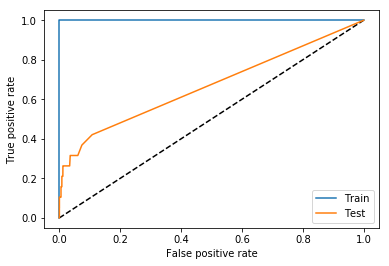

In [12]:
n_estimators_RF = [50, 100, 250, 500, 1000]
max_features_RF = [ None]
parameters_RF = {'n_estimators': n_estimators_RF,
                'max_features': max_features_RF}

RF_model = RandomForestClassifier(max_depth=None,
                                  min_samples_split=2, random_state=0)
RF_clf = GridSearchCV(RF_model, parameters_RF, cv=5, scoring=kappa_scorer)
RF_clf, RF_performance, RF_train, RF_test = fit_model(RF_clf, X_train, X_test, y_train, y_test)

RF_train = pd.concat([RF_train, AG_geneIDs_train], axis=1)
RF_test = pd.concat([RF_test, AG_geneIDs_test], axis=1)

RF_train.to_csv('RF_train_noDAP_outcome022619.csv')
RF_test.to_csv('RF_test_noDAP_outcome022619.csv')

Best Model:
MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(40, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Training set confusion matrix:
[[16784     1]
 [    3    52]]
Test set confusion matrix:
[[9392   30]
 [  18    1]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.999762       0.994916     0.962844    0.037598


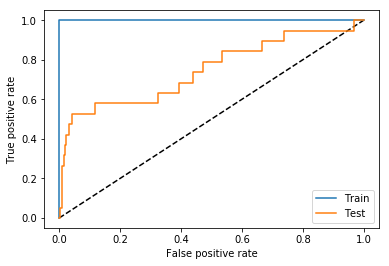

In [14]:
alpha_MLP = [i for i in 10.0 ** -np.arange(1,7)]
hidden_layer_sizes_MLP = [(10,10), (20,20), (40,40), 
                     (10,20),(10,40),(20,10), (40,10)]
parameters_MLP = {'alpha': alpha_MLP,
                 'hidden_layer_sizes': hidden_layer_sizes_MLP}

MLP_model = MLPClassifier(solver='lbfgs', 
                    random_state=1)
MLP_clf = GridSearchCV(MLP_model, parameters_MLP, cv=5, scoring=kappa_scorer)
MLP_clf, MLP_performance, MLP_train, MLP_test = fit_model(MLP_clf, X_train, X_test, y_train, y_test)

MLP_train = pd.concat([MLP_train, AG_geneIDs_train], axis=1)
MLP_test = pd.concat([MLP_test, AG_geneIDs_test], axis=1)

MLP_train.to_csv('MLP_train_noDAP_outcome022619.csv')
MLP_test.to_csv('MLP_test_noDAP_outcome022619.csv')

In [15]:
with open('../predictors/predictors0226_noDAP_testRIFPENCIP.pkl','wb') as f:
    pickle.dump([DT_clf, LR_clf, SVM_clf, KNN_clf, RF_clf, MLP_clf], f)

Consensus cluster - first try majority vote. Then try weighing the majority vote by training kappa

In [16]:
allclf_train = AG_geneIDs_train
allclf_train['DT'] = DT_clf.best_estimator_.predict_proba(X_train)[:,1]
allclf_train['KNN'] = KNN_clf.best_estimator_.predict_proba(X_train)[:,1]
allclf_train['SVC'] = SVM_clf.best_estimator_.predict_proba(X_train)[:,1]
allclf_train['LR'] = LR_clf.best_estimator_.predict_proba(X_train)[:,1]
allclf_train['RF'] = RF_clf.best_estimator_.predict_proba(X_train)[:,1]
allclf_train['MLP'] = MLP_clf.best_estimator_.predict_proba(X_train)[:,1]

allclf_train['consensus_proba'] = allclf_train[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']].mean(axis=1)

allclf_test = AG_geneIDs_test
allclf_test['DT'] = DT_clf.best_estimator_.predict_proba(X_test)[:,1]
allclf_test['KNN'] = KNN_clf.best_estimator_.predict_proba(X_test)[:,1]
allclf_test['SVC'] = SVM_clf.best_estimator_.predict_proba(X_test)[:,1]
allclf_test['LR'] = LR_clf.best_estimator_.predict_proba(X_test)[:,1]
allclf_test['RF'] = RF_clf.best_estimator_.predict_proba(X_test)[:,1]
allclf_test['MLP'] = MLP_clf.best_estimator_.predict_proba(X_test)[:,1]

X_consensus_train = allclf_train[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']]
X_consensus_test = allclf_test[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']]

D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [28]:
allclf_train['MajVoteProb'] = allclf_train[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']].sum(axis=1)/6

allclf_test['MajVoteProb'] = allclf_test[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']].sum(axis=1)/6


D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
def eval_model(y_predprob_train, y_predprob_test, trainoutcome, testoutcome):
    
    y_pred_train = y_predprob_train>0.5
    y_pred_test = y_predprob_test>0.5
    
    fpr_train, tpr_train, _ = roc_curve(trainoutcome, y_predprob_train)
    fpr_test, tpr_test, _ = roc_curve(testoutcome, y_predprob_test)
    
    acc_train = accuracy_score(trainoutcome, y_pred_train)
    acc_test = accuracy_score(testoutcome, y_pred_test)
    kap_train = cohen_kappa_score(trainoutcome, y_pred_train)
    kap_test = cohen_kappa_score(testoutcome, y_pred_test)
    
    cm_train = confusion_matrix(trainoutcome, y_pred_train)
    cm_test = confusion_matrix(testoutcome, y_pred_test)
    print("Training set confusion matrix:")
    print(cm_train)
    print("Test set confusion matrix:")
    print(cm_test)
    
    x = pd.DataFrame({'Train_Accuracy': [acc_train],
        'Test_Accuracy': [acc_test],
        'Train_Kappa': [kap_train],
        'Test_Kappa': [kap_test]})
    print(x)
    train_outcome_df = pd.DataFrame({'Outcome': trainoutcome,
                                    'Predicted': y_pred_train})
    test_outcome_df = pd.DataFrame({'Outcome': testoutcome,
                                   'Predicted': y_pred_test})
    
    
    # plot ROC
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot(fpr_test, tpr_test, label='Test')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.show()
    

Training set confusion matrix:
[[16785     0]
 [    0    55]]
Test set confusion matrix:
[[9419    3]
 [  17    2]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0             1.0       0.997882          1.0    0.165967


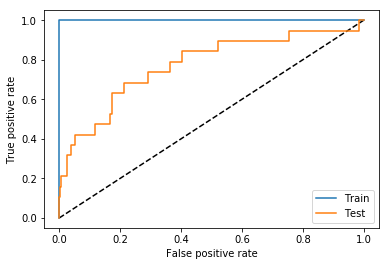

In [32]:
eval_model(allclf_train['MajVoteProb'], allclf_test['MajVoteProb'], y_train, y_test)

Now weigh the predicted probabilities by their respective kappas

In [36]:
DT_kappa = cohen_kappa_score(allclf_train.DT>0.5, y_train)
KNN_kappa = cohen_kappa_score(allclf_train.KNN>0.5, y_train)
SVC_kappa = cohen_kappa_score(allclf_train.SVC>0.5, y_train)
LR_kappa = cohen_kappa_score(allclf_train.LR>0.5, y_train)
RF_kappa = cohen_kappa_score(allclf_train.RF>0.5, y_train)
MLP_kappa = cohen_kappa_score(allclf_train.MLP>0.5, y_train)

allclf_train['WtdMajVoteProb'] = (allclf_train.DT * DT_kappa + allclf_train.KNN * KNN_kappa +
                                 allclf_train.SVC*SVC_kappa + allclf_train.LR*LR_kappa +
                                 allclf_train.RF*RF_kappa + allclf_train.MLP*MLP_kappa)/(DT_kappa+KNN_kappa+SVC_kappa+LR_kappa+RF_kappa+MLP_kappa)

allclf_test['WtdMajVoteProb'] = (allclf_test.DT * DT_kappa + allclf_test.KNN * KNN_kappa +
                                 allclf_test.SVC*SVC_kappa + allclf_test.LR*LR_kappa +
                                 allclf_test.RF*RF_kappa + allclf_test.MLP*MLP_kappa)/(DT_kappa+KNN_kappa+SVC_kappa+LR_kappa+RF_kappa+MLP_kappa)



D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Training set confusion matrix:
[[16785     0]
 [    0    55]]
Test set confusion matrix:
[[9413    9]
 [  18    1]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0             1.0        0.99714          1.0    0.067672


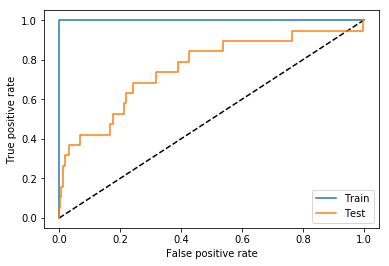

In [37]:
eval_model(allclf_train['WtdMajVoteProb'], allclf_test['WtdMajVoteProb'], y_train, y_test)

In [38]:
allclf_train.to_csv('../predictors/022619/Consensus_train022619.csv')
allclf_test.to_csv('../predictors/022619/Consensus_test022619.csv')